In [1]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
def step(t, dt):
    t = t + dt
    return t

In [3]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            
#                     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
#                     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

In [4]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [5]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below

#         if self.view_max > end_row:
#             self.view_max = end_row + self.width / 2
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > self.view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind?
        if len(self.fruitBTree) > 0:
            self.passedFruit()
            
        self.i_lastFruit = j
        
    
    def passedFruit(self):  
        # removal of all smaller keys than the vehicle's edge from B-Tree
        edge_key  = math.ceil(self.view_min*1000) # edge being passed
        
        try: # if no key exists after the potential key, break out rather than crash the program
            max_key_pop = self.fruitBTree.maxKey(edge_key)
            
            for k in self.fruitBTree.keys():
                if k < max_key_pop:
                    # so it doesn'thave to go through the whole B-Tree
                    self.passed_fruit.append(self.fruitBTree.pop(k))
                else:
                    break         

        except ValueError:
#             print("*** No key smaller than the edge value, broke out of the if statement ***")
            return
            
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [6]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [7]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n, max_vel, max_accel):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        self.state         = 0                           # arm's state to log % time used for each activity
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q[1],q[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        self.goals_given   = 0     # how many goals were given to the arm (to check against how many it reached)
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        self.unloadFlag    = 0     # checks if the arm's moving to the conveyor
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        self.tz            = 0.      # time used for unloading the fruit on conveyor (only z-dir)        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])
        
        epsilon     = 0.001           # allowable error when reaching fruit

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        if self.unloadFlag == 2: # if the arm is unloading
            goal_time_z = t - self.t_unload
        else:
            goal_time_z = goal_time 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time_z)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted or fruit unloaded
            # akes sure that these actions can still happen even if the arm's frame has moved beyond the fruit
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
    
                if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's retracting before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0
                    print("Fruit skipped")
                    
            elif self.unloadFlag != 0: # and q_curr[0] == self.q_f[0]:
                # move down to the conveyor to drop off the fruit
                self.calcZVel(goal_time_z)

        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
        # stop the arm from moving below the bottom of the frame
        if self.q_a[2] < self.q_f[2] - self.height_f / 2:
            self.q_a[2] = self.q_f[2] - self.height_f / 2
            
        # stop the arm from moving behind it's frame
        if self.q_a[1] < self.q_f[1] - self.width_f / 2:
            self.q_a[1] = self.q_f[1] - self.width_f / 2
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.n == 1 and self.row_n == 1:
#             print("")
#             print("Row:", self.row_n, "Arm:", self.n)
#             print("Edges, X:", self.x_edges_f, "Y:", self.y_edges_f, "Z:", self.z_edges_f)
#             print("Goal: {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("Current location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#             print("")
#             print("Goals reached:", self.goal_r)
#             print("retracting:", self.retractFlag)
#             print("unloading", self.unloadFlag)
#             print("can it reach?", can_reach)
#             print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
                # set unloading flag to one so that once retraction finishes, unloading can begin
                self.unloadFlag = 1
                
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
                
            elif self.unloadFlag == 2 and goal_time_z == goal_time: # will only happen once with the AND
                # if retraction is done, but fruit has not been dropped off
                self.unload()
                # restart the timers
                self.t_unload    = t      # start time for the new timer for unloading
                goal_time_z      = 0.
                
            elif self.retractFlag == 0 and self.unloadFlag != 2:
                # set the arm as free only if there is no need to retract or drop of fthe fruit or fruit cannot be reached
                self.tx         = 0.
                self.free       = 1 
                self.x_move     = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0]  = 0
                self.goal_r[1]  = 0
                self.goal_r[2]  = 0
                # reset the unloading flag 
                self.unloadFlag = 0
                # set state back to idle 
                self.state = 0
                        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        self.retractFlag = 1
        self.state = 2
        
    
    def unload(self):
        # calculates the trajectory for the arm from curr position to bottom 
        # of the frame (conveyor location) and sets the flag as run the unload sequence
        # should only run if fruit has been obtained and the arm has retracted
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
        # set state to unloading
        self.state = 3
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0.) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        # calculate the trapezoidal times for each of the three movement stages (change to S-curve later)
        self.trapTimes()
        # maybe start time here? => evaluate how that could change things once in real time
        self.t = t
        # set state as picking 
        self.state = 1
        # increase goals given counter
        self.goals_given += 1
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong ==> looking at Zhenghao's work, he assumes constant. However, this is better
        # at the scheduling level
        # ==> becomes just a check for when assuming constant vehicle velocity doesn't work :)
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            # if the unloadflag was primed by reaching the goal, move the flag to "unload state on"
            if self.unloadFlag == 1:
                self.unloadFlag = 2
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
            # set unload flag as done if it was triggered to move at the end of retract 
            if self.unloadFlag == 2:
                self.unloadFlag = 0
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [8]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [9]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 12.  # end of the row (when the mid-point of vehicle reaches this point it stops)
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

# create empty list which will save arm states
arm_states = []

In [10]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.007])   # in m, constant velocity   => got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

qv0 = []
qv1 = []

In [11]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [12]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [13]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of 1st arm in vehicle frame
q_a_new = np.array([0.,0.,0.]) 

max_v = 1.
max_a = 10.

arm_offset = 0.75 / (num_row_arms-1) # divide by num of arms because it's going to be inverted diagonal vs row num

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        # fruit's in a diagonal, so get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_a[0] + 0.3 + ((num_row_arms-1)*arm_offset - arm_offset*rows)  
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows, max_v, max_a)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [14]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1
                        # give the arm the index so that it can set it back to 0 if it does not reach it
                        a[rows,arm_free].goal_index = goal_new
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)                     
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # create arm state object?
    for rows in range(num_row_arms):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].state])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: 7.35 9.8678696059 0.0
start, end, start velocity: 6.0 5.3231695488 0.0
start, end, start velocity: 1.5 1.1919865482 0.0
start, end, start velocity: 7.35 9.9191284757 0.0
start, end, start velocity: 9.0 7.5732524703 0.0
start, end, start velocity: 1.5 1.4549112491 0.0
start, end, start velocity: 7.35 9.0836432909 0.0
start, end, start velocity: 12.0 10.794768294 0.0
start, end, start velocity: 1.5 0.9577824011 0.0
start, end, start velocity: 6.975 7.8880462924 0.0
start, end, start velocity: 6.0 5.9278863172 0.0
start, end, start velocity: 4.5 4.2075675354 0.0
start, end, start velocity: 6.975 8.2155859972 0.0
start, end, start velocity: 9.0 7.5099152899 0.0
start, end, start velocity: 4.5 3.7314053709 0.0
start, end, start velocity: 6.975 7.7962720949 0.0
start, end, start velocity: 12.0 10.5610279055 0.0
start, end, start velocity: 4.5 4.0949260327 0.0
start, end, start velocity: 6.6 7.5979936552 0.0
start, end, start velocity: 6.0 6.0434705216 0.0
start, e

start, end, start velocity: 8.44264284309981 7.35 0
start, end, start velocity: 6.975 6.6755721912 0.0
start, end, start velocity: 6.057408745734538 6.0797237886 0.0
start, end, start velocity: 3.0000000000001847 5.981443497 0.0
start, end, start velocity: 6.97500000000001 8.5344866263 0.0
start, end, start velocity: 7.704962187132743 7.8259371868 0.0
start, end, start velocity: 3.000000000000224 3.5148481657 0.0
start, end, start velocity: 7.885824963299839 6.975 0
start, end, start velocity: 6.6 7.5974740466 0.0
start, end, start velocity: 11.621587182199987 11.6979601647 0.0
start, end, start velocity: 6.000000000000346 8.5857387803 0.0
start, end, start velocity: 7.35 9.8379219787 0.0
start, end, start velocity: 7.626349999998488 7.6498684396 0.0
start, end, start velocity: 3.070452963063741e-13 0.5574614491 0.0
start, end, start velocity: 2.326157407100045 0.0 0.0
start, end, start velocity: 3.9885376831998913 3.0 0.0
start, end, start velocity: 6.83021682249996 6.6 0
start, end, 

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.975000000000206 8.720551808 0.0
start, end, start velocity: 7.8724089008832765 7.9836538979 0.0
start, end, start velocity: 3.000000000000293 4.2202653589 0.0
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 7.35000000000017 8.5112964451 0.0
start, end, start velocity: 11.131203271000006 11.225894179 0.0
start, end, start velocity: 4.0230243181921255e-13 2.6594242893 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 7.3500000000002 8.4175292935 0.0
start, end, start velocity: 7.698309999997636 7.7596540663 0.0
start, end, start velocity: 1.238443004299807 1.8771065745 0.0
start, end, start velocity: 7.4161710571999215 6.975

start, end, start velocity: 3.477485045000085 3.0 0.0
start, end, start velocity: 6.6 7.4320158809 0.0
start, end, start velocity: 7.847897849385995 7.9052371486 0.0
start, end, start velocity: 7.678832773500298 7.5435204009 0.0
start, end, start velocity: 8.54323646330028 6.975 0
start, end, start velocity: 5.0605873747003685 3.0 0.0
start, end, start velocity: 6.6 7.4227663661 0.0
start, end, start velocity: 6.497170149471088 6.5158234232 0.0
start, end, start velocity: 6.0 7.5474660095 0.0
start, end, start velocity: 1.3078703716002595 0.0 0.0
start, end, start velocity: 6.975 8.0922558169 0.0
start, end, start velocity: 11.102563442974674 11.1218544403 0.0
start, end, start velocity: 3.0 4.0655523778 0.0
start, end, start velocity: 9.121972238900316 7.35 0
start, end, start velocity: 7.334901509300238 6.0 0.0
start, end, start velocity: 2.6322168487005126 0.0 0.0
start, end, start velocity: 7.432015880900149 6.6 0
start, end, start velocity: 4.85523387900033 3.0 0.0
start, end, sta

start, end, start velocity: 6.982286171299794 6.6 0
start, end, start velocity: 9.774621781298709 7.35 0
start, end, start velocity: 4.2872785658993156 3.0 0.0
start, end, start velocity: 8.538211024999168 6.975 0
start, end, start velocity: 8.572787582298629 6.0 0.0
start, end, start velocity: 6.713257029599939 6.6 0
start, end, start velocity: 8.516690254498661 6.0 0.0
start, end, start velocity: 7.5266841688991875 6.0 0.0
start, end, start velocity: 3.1303465071999277 3.0 0.0
start, end, start velocity: 6.975000000000845 7.8516511945 0.0
start, end, start velocity: 11.362230816734192 11.4035717822 0.0
start, end, start velocity: 3.000000000000073 5.2706588049 0.0
start, end, start velocity: 6.975000000000515 7.6097038563 0.0
start, end, start velocity: 6.466513824322822 6.4919825658 0.0
start, end, start velocity: 3.0000000000006857 5.5003876913 0.0
start, end, start velocity: 9.781006518398701 7.35 0
start, end, start velocity: 4.889414218398995 3.0 0.0
start, end, start velocity: 

start, end, start velocity: 9.211643534399007 7.35 0
start, end, start velocity: 7.095323084699736 6.6 0
start, end, start velocity: 7.722407607499401 6.6 0
start, end, start velocity: 7.978781867199464 6.975 0
start, end, start velocity: 7.976378418798947 6.0 0.0
start, end, start velocity: 3.2831798142998476 3.0 0.0
start, end, start velocity: 0.9231513817995247 0.0 0.0
start, end, start velocity: 8.018708125799442 6.975 0
start, end, start velocity: 9.169879231199031 7.35 0
start, end, start velocity: 6.9750000000012236 8.6442841426 0.0
start, end, start velocity: 8.350173922779947 8.3743083841 0.0
start, end, start velocity: 3.0000000000001528 4.6543243244 0.0
start, end, start velocity: 0.8625541377995554 0.0 0.0
start, end, start velocity: 7.139543697299395 6.0 0.0
start, end, start velocity: 5.052131774998905 3.0 0.0
start, end, start velocity: 7.350000000001293 9.0757881807 0.0
start, end, start velocity: 5.878439455866984 5.8831005433 0.0
start, end, start velocity: 4.75136260

start, end, start velocity: 9.333058668998941 7.35 0
start, end, start velocity: 4.340675943999283 3.0 0.0
start, end, start velocity: 7.350000000000483 8.977494768 0.0
start, end, start velocity: 11.583755579727788 11.606009938 0.0
start, end, start velocity: 1.1641427839076401e-12 2.9352271607 0.0
start, end, start velocity: 6.701316067299624 6.0 0.0
start, end, start velocity: 7.38193303739958 6.6 0
start, end, start velocity: 9.480727382098863 7.35 0
start, end, start velocity: 6.6000000000004775 6.7368066887 0.0
start, end, start velocity: 8.55820139099993 8.6387930685 0.0
start, end, start velocity: 6.000000000000377 7.7587742128 0.0
start, end, start velocity: 7.377488220299586 6.6 0
start, end, start velocity: 6.975000000000573 7.5264664522 0.0
start, end, start velocity: 6.655056617640709 6.6765618552 0.0
start, end, start velocity: 3.0000000000007176 5.4654702567 0.0
start, end, start velocity: 6.691648913199629 6.0 0.0
start, end, start velocity: 1.3094137721993309 0.0 0.0
s

start, end, start velocity: 6.975 8.0014659565 0.0
start, end, start velocity: 11.77288496105873 11.8009528641 0.0
start, end, start velocity: 3.0 5.6932471143 0.0
start, end, start velocity: 6.6 7.5348314402 0.0
start, end, start velocity: 8.813103927459741 8.8202325854 0.0
start, end, start velocity: 6.0 6.3448542481 0.0
start, end, start velocity: 0.6630449638006007 0.0 0.0
start, end, start velocity: 7.476000073900774 6.6 0
start, end, start velocity: 3.1890154078994737 3.0 0.0
start, end, start velocity: 7.4723114693007755 6.6 0
start, end, start velocity: 3.20373925750018 3.0 0.0
start, end, start velocity: 6.975 7.9985286833 0.0
start, end, start velocity: 8.485392771401232 8.5129762637 0.0
start, end, start velocity: 3.0 5.1790289727 0.0
start, end, start velocity: 7.35 8.8259362025 0.0
start, end, start velocity: 6.203433354465278 6.2305486381 0.0
start, end, start velocity: 0.0 2.8530838851 0.0
start, end, start velocity: 6.975 8.4100900078 0.0
start, end, start velocity: 6.9

start, end, start velocity: 4.792741176001591 3.0 0.0
start, end, start velocity: 6.975 8.0655797807 0.0
start, end, start velocity: 8.579000795378194 8.5897312792 0.0
start, end, start velocity: 3.0 4.9481375298 0.0
start, end, start velocity: 6.975 8.2913312067 0.0
start, end, start velocity: 11.850503754788917 11.8671078268 0.0
start, end, start velocity: 3.0 4.2585087014 0.0
start, end, start velocity: 6.698096102300616 6.0 0.0
start, end, start velocity: 6.6 6.965092771 0.0
start, end, start velocity: 8.992982418894865 9.2397614633 0.0
start, end, start velocity: 6.0 6.8839762436 0.0
start, end, start velocity: 9.034473368501496 7.35 0
start, end, start velocity: 6.6 6.9650695519 0.0
start, end, start velocity: 12.613951108521812 12.6582144892 0.0
start, end, start velocity: 6.0 7.0051504565 0.0
start, end, start velocity: 0.7343667889006643 0.0 0.0
start, end, start velocity: 7.481501535800783 6.6 0
start, end, start velocity: 6.975 8.1115651567 0.0
start, end, start velocity: 8.

start, end, start velocity: 6.6 7.3995379972 0.0
start, end, start velocity: 9.426336784877 9.4609559341 0.0
start, end, start velocity: 6.0 7.5468876724 0.0
start, end, start velocity: 6.962693425300856 6.0 0.0
start, end, start velocity: 6.6 6.778988858 0.0
start, end, start velocity: 9.387126722464105 9.4881968309 0.0
start, end, start velocity: 6.0 6.0790498136 0.0
start, end, start velocity: 8.627000234401468 6.975 0
start, end, start velocity: 6.778988858000153 6.6 0
start, end, start velocity: 6.0790379317737635 6.0 0.0
start, end, start velocity: 7.920877157600836 6.975 0
start, end, start velocity: 6.6 7.2025274 0.0
start, end, start velocity: 12.686801499071125 12.6993695422 0.0
start, end, start velocity: 6.0 8.5572339296 0.0
start, end, start velocity: 6.6 6.4910166732 0.0
start, end, start velocity: 9.488196830900074 9.4940155184 0.0
start, end, start velocity: 6.000012027949654 6.4902071094 0.0
start, end, start velocity: 7.35 9.7752470513 0.0
start, end, start velocity: 

start, end, start velocity: 3.5620252135004993 3.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.975 8.7878274632 0.0
start, end, start velocity: 7.442839042051776 8.8226369836 0.0
start, end, start velocity: 3.0 4.3690321429 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 4.698410267701503 3.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 4.852841871001646 3.0 0.0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fr

start, end, start velocity: 8.416897765900943 7.35 0
start, end, start velocity: 6.890151584700259 6.6 0
start, end, start velocity: 7.409953009700384 6.975 0
start, end, start velocity: 6.6 7.3379131754 0.0
start, end, start velocity: 12.870413609360027 12.9009622819 0.0
start, end, start velocity: 6.0 8.2815116574 0.0
start, end, start velocity: 7.35 8.704908107 0.0
start, end, start velocity: 9.433602577295739 9.457197231 0.0
start, end, start velocity: 0.0 1.1687968676 0.0
start, end, start velocity: 6.957407916700847 6.0 0.0
start, end, start velocity: 5.088598054301849 3.0 0.0
start, end, start velocity: 9.309911540901734 7.35 0
start, end, start velocity: 2.1370069262019373 0.0 0.0
start, end, start velocity: 3.2392319160002065 3.0 0.0
start, end, start velocity: 6.6 7.8357416975 0.0
start, end, start velocity: 10.162779322046225 10.1966781231 0.0
start, end, start velocity: 6.0 6.2388188019 0.0
start, end, start velocity: 6.975 8.7004592537 0.0
start, end, start velocity: 8.976

start, end, start velocity: 7.35 9.1578855873 0.0
start, end, start velocity: 6.720518021265034 6.7459158822 0.0
start, end, start velocity: 0.0 2.6804665443 0.0
start, end, start velocity: 6.975 7.4634880886 0.0
start, end, start velocity: 9.389512395141109 9.487951214 0.0
start, end, start velocity: 3.0 4.1829331383 0.0
start, end, start velocity: 7.52966010350082 6.6 0
start, end, start velocity: 8.666731471601167 7.35 0
start, end, start velocity: 8.001937599800907 6.975 0
start, end, start velocity: 4.189161711748286 3.0 0.0
start, end, start velocity: 8.52002775930104 7.35 0
start, end, start velocity: 7.700774167001512 6.0 0.0
start, end, start velocity: 4.913339930401699 3.0 0.0
start, end, start velocity: 6.975 7.8975932047 0.0
start, end, start velocity: 12.08614103044014 12.1434428535 0.0
start, end, start velocity: 3.0 4.6893761432 0.0
start, end, start velocity: 2.1924876823019903 0.0 0.0
start, end, start velocity: 7.463488088600428 6.975 0
start, end, start velocity: 1.6

start, end, start velocity: 7.151361785700491 6.6 0
start, end, start velocity: 9.727568840702109 7.35 0
start, end, start velocity: 6.975 7.8128558285 0.0
start, end, start velocity: 9.67467882696263 9.7940089514 0.0
start, end, start velocity: 3.0 5.956881877 0.0
start, end, start velocity: 6.29995045390026 6.0 0.0
start, end, start velocity: 6.6 7.150269511 0.0
start, end, start velocity: 13.421333558656302 13.4373429016 0.0
start, end, start velocity: 6.0 6.2898844337 0.0
start, end, start velocity: 7.35 8.9831507327 0.0
start, end, start velocity: 9.619386377300827 9.6219782235 0.0
start, end, start velocity: 0.0 1.3365322907 0.0
start, end, start velocity: 6.975 8.598724228 0.0
start, end, start velocity: 9.738781241300083 9.8198691861 0.0
start, end, start velocity: 3.0 3.0000779706 0.0
start, end, start velocity: 7.195854182600197 6.975 0
start, end, start velocity: 5.851638030602533 3.0 0.0
start, end, start velocity: 7.1502695110004915 6.6 0
start, end, start velocity: 0.8374

start, end, start velocity: 0.8726229114007918 0.0 0.0
start, end, start velocity: 7.35 8.5280770461 0.0
start, end, start velocity: 9.839468726714657 9.9096227391 0.0
start, end, start velocity: 0.0 1.8611744558 0.0
start, end, start velocity: 7.35 8.9244470079 0.0
start, end, start velocity: 6.917020432935913 6.943765763 0.0
start, end, start velocity: 0.0 2.4352775267 0.0
start, end, start velocity: 7.255585047200579 6.6 0
start, end, start velocity: 4.077024238600952 3.0 0.0
start, end, start velocity: 7.70569812530065 6.975 0
start, end, start velocity: 7.35 9.5140522931 0.0
start, end, start velocity: 12.600092613123506 12.6205255794 0.0
start, end, start velocity: 0.0 0.9451032882 0.0
start, end, start velocity: 7.125620427300998 6.0 0.0
start, end, start velocity: 7.646122358000598 6.975 0
start, end, start velocity: 4.047877097000926 3.0 0.0
start, end, start velocity: 6.975 8.4014039995 0.0
start, end, start velocity: 10.374644714580553 10.3794248121 0.0
start, end, start vel

start, end, start velocity: 7.223852065200216 6.975 0
start, end, start velocity: 0.29713951580026376 0.0 0.0
start, end, start velocity: 5.438321826302161 3.0 0.0
start, end, start velocity: 7.35 8.3811143274 0.0
start, end, start velocity: 12.771824587225197 12.7862381365 0.0
start, end, start velocity: 0.0 0.5836240405 0.0
start, end, start velocity: 8.60868643290145 6.975 0
start, end, start velocity: 7.35 9.7021619298 0.0
start, end, start velocity: 10.147216360701968 10.1957204438 0.0
start, end, start velocity: 0.0 0.7261689442 0.0
start, end, start velocity: 6.6 6.9742384489 0.0
start, end, start velocity: 13.744293414330825 13.7474502654 0.0
start, end, start velocity: 6.0 7.5890096661 0.0
start, end, start velocity: 9.723062166202109 7.35 0
start, end, start velocity: 4.00206626400089 3.0 0.0
start, end, start velocity: 8.381114327400919 7.35 0
start, end, start velocity: 6.974238448900332 6.6 0
start, end, start velocity: 6.975 7.1830532478 0.0
start, end, start velocity: 12

start, end, start velocity: 0.7719053887007009 0.0 0.0
start, end, start velocity: 9.094515366201547 7.35 0
start, end, start velocity: 5.496812538802214 3.0 0.0
start, end, start velocity: 7.209422609400535 6.6 0
start, end, start velocity: 7.35 8.9909346302 0.0
start, end, start velocity: 11.78374204580123 11.874570266 0.0
start, end, start velocity: 0.0 2.3026246165 0.0
start, end, start velocity: 7.253394267001113 6.0 0.0
start, end, start velocity: 6.975 7.7247303114 0.0
start, end, start velocity: 13.133623899717367 13.2112999291 0.0
start, end, start velocity: 3.0 4.9674553176 0.0
start, end, start velocity: 0.37115202920033663 0.0 0.0
start, end, start velocity: 7.35 9.7301875654 0.0
start, end, start velocity: 7.250296389681722 7.2932981744 0.0
start, end, start velocity: 0.0 2.4670029682 0.0
start, end, start velocity: 6.6 7.6613105293 0.0
start, end, start velocity: 13.955813074985674 14.3261005607 0.0
start, end, start velocity: 6.0 7.3557085059 0.0
start, end, start veloci

start, end, start velocity: 7.299047863900616 6.6 0
start, end, start velocity: 9.595898578001991 7.35 0
start, end, start velocity: 6.975 9.1419494637 0.0
start, end, start velocity: 13.499498454525442 13.5295086438 0.0
start, end, start velocity: 3.0 3.5765707791 0.0
start, end, start velocity: 6.941417976900837 6.0 0.0
start, end, start velocity: 7.35 8.1986270516 0.0
start, end, start velocity: 13.50210496372313 13.5243196291 0.0
start, end, start velocity: 0.0 2.7731005505 0.0
start, end, start velocity: 6.6 6.9949230252 0.0
start, end, start velocity: 14.497756582203184 14.5099774852 0.0
start, end, start velocity: 6.0 7.0081995862 0.0
start, end, start velocity: 0.9178840206008282 0.0 0.0
start, end, start velocity: 6.975 9.097175204 0.0
start, end, start velocity: 13.500744743831502 13.5305422916 0.0
start, end, start velocity: 3.0 3.6634634441 0.0
start, end, start velocity: 7.35 8.5909147365 0.0
start, end, start velocity: 13.513320507071267 13.5942969236 0.0
start, end, star

start, end, start velocity: 8.737775955201228 7.35 0
start, end, start velocity: 9.203944679101975 6.975 0
start, end, start velocity: 7.227364742300553 6.6 0
start, end, start velocity: 8.700560691101202 7.35 0
start, end, start velocity: 6.979761818200863 6.0 0.0
start, end, start velocity: 7.8565947507007845 6.975 0
start, end, start velocity: 1.3432755943012198 0.0 0.0
start, end, start velocity: 1.3529722848012287 0.0 0.0
start, end, start velocity: 6.6 8.0757184529 0.0
start, end, start velocity: 14.66580946106512 14.6696042984 0.0
start, end, start velocity: 6.0 6.8076926836 0.0
start, end, start velocity: 4.447525486401281 3.0 0.0
start, end, start velocity: 3.2898502079002503 3.0 0.0
start, end, start velocity: 6.975 9.1190158484 0.0
start, end, start velocity: 13.948287101271863 13.9922682322 0.0
start, end, start velocity: 3.0 3.3421779876 0.0
start, end, start velocity: 7.35 9.3636572229 0.0
start, end, start velocity: 13.746042716385679 13.7764544809 0.0
start, end, start 

In [15]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)


program took: 12.85323429107666 sec
total internal time: 428.5799999997552
total vehicle distance moved: 5.700059999962556
total number of fruit in CSV file: 2638

vehicle speed: 0.007 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

total fruit reached for arm 0 in row 0 is 80
total fruit reached for arm 1 in row 0 is 112
total fruit reached for arm 2 in row 0 is 113
total fruit reached for arm 0 in row 1 is 97
total fruit reached for arm 1 in row 1 is 128
total fruit reached for arm 2 in row 1 is 131
total fruit reached for arm 0 in row 2 is 63
total fruit reached for arm 1 in row 2 is 86
total fruit reached for arm 2 in row 2 is 161
Total picked fruit: 971  and sec/pick fruit: 0.44138002059707027


In [26]:
# analyze the % time each arm is in each state 
# print(arm_states[:10])
idle = 0.
picking = 0.
retracting = 0.
unloading = 0.

tot_num_arms = num_arms*num_row_arms

step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],step] = arm_num[1]
        
        if arm_num[1] == 0:
            idle += 1
        elif arm_num[1] == 1:
            picking += 1
        elif arm_num[1] == 2:
            retracting += 1
        elif arm_num[1] == 3:
            unloading += 1
        
    step += 1
        
idle_arm = 0.
pick_arm = 0.
retr_arm = 0.
unlo_arm = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot = []
pick_plot = []
retr_plot = []
unlo_plot = []


# for each arm
for i in range(9):
    for x in state_data[i]:
        if x == 0:
            idle_arm += 1
        elif x == 1:
            pick_arm += 1
        elif x == 2:
            retr_arm += 1
        elif x == 3:
            unlo_arm += 1
    
    total = idle_arm + pick_arm + retr_arm + unlo_arm
    
    idle_plot.append(idle_arm)
    pick_plot.append(pick_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    if i%num_row_arms == 0:
        row_n = math.floor(i/num_row_arms)
        arm_n = 0
        
    print("Arm", arm_n, "in row", row_n)
    print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
    print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
    print("")
    
    idle_arm = 0.
    pick_arm = 0.
    retr_arm = 0.
    unlo_arm = 0.



Arm 0 in row 0
Idle: 5958.0 [unitless], Picking: 18375.0 [unitless], Retracting: 9184.0 [unitless], Unloading: 9341.0 [unitless]
Idle: 13.9017 [%], Picking: 42.8741 [%], Retracting: 21.4289 [%], Unloading: 21.7952 [%]

Arm 1 in row 0
Idle: 69.0 [unitless], Picking: 21385.0 [unitless], Retracting: 10825.0 [unitless], Unloading: 10579.0 [unitless]
Idle: 0.1610 [%], Picking: 49.8973 [%], Retracting: 25.2578 [%], Unloading: 24.6838 [%]

Arm 2 in row 0
Idle: 66.0 [unitless], Picking: 21438.0 [unitless], Retracting: 9606.0 [unitless], Unloading: 11748.0 [unitless]
Idle: 0.1540 [%], Picking: 50.0210 [%], Retracting: 22.4136 [%], Unloading: 27.4115 [%]

Arm 0 in row 1
Idle: 13072.0 [unitless], Picking: 15232.0 [unitless], Retracting: 6146.0 [unitless], Unloading: 8408.0 [unitless]
Idle: 30.5007 [%], Picking: 35.5406 [%], Retracting: 14.3404 [%], Unloading: 19.6183 [%]

Arm 1 in row 1
Idle: 80.0 [unitless], Picking: 22005.0 [unitless], Retracting: 10410.0 [unitless], Unloading: 10363.0 [unitles

<IPython.core.display.Javascript object>


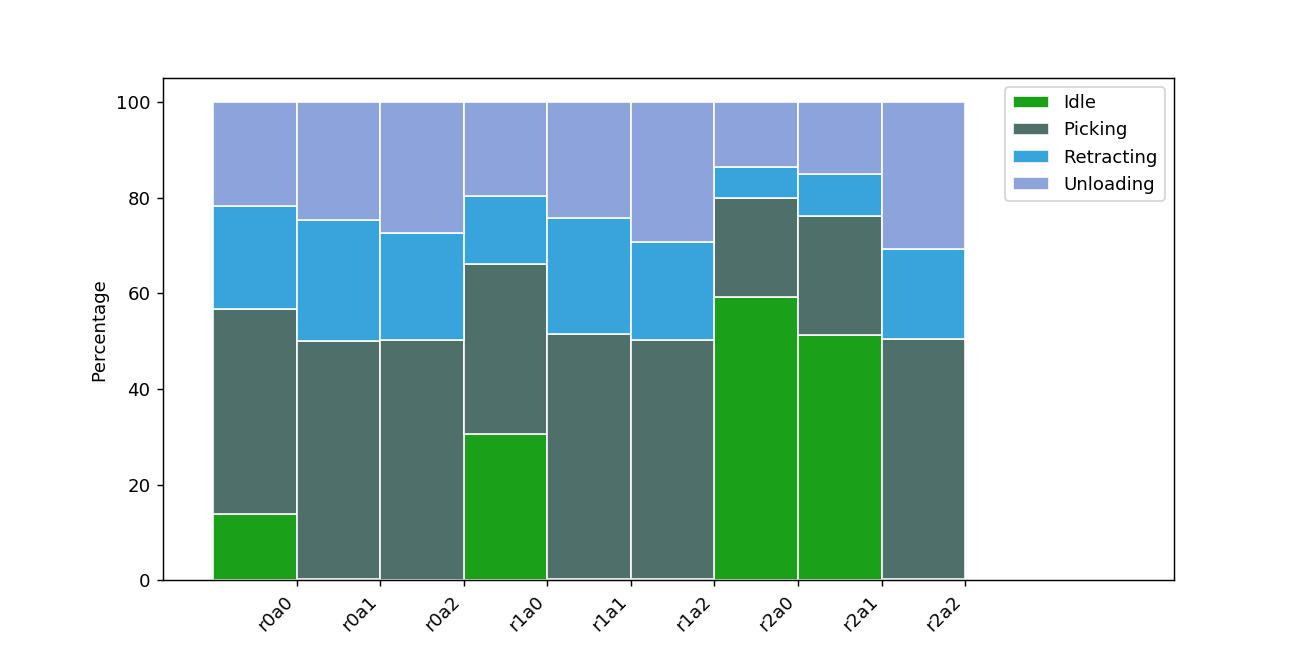

In [61]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

names = ["r0a0", "r0a1", "r0a2","r1a0", "r1a1", "r1a2","r2a0", "r2a1", "r2a2",]

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(len(idle_plot))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create the total steps per state
totals = [i+j+k+l for i,j,k,l in zip(idle_plot, pick_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for picking state
per_pick = [i / j * 100 for  i,j in zip(pick_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#019600',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pick, 
       # with pre_rel
       bottom=per_idle, 
       # labeled 
       label='Picking', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3C5F5A', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j for i,j in zip(per_idle, per_pick)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#219AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pick, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#819AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

plt.xticks(tick_pos, names)

ax.set_ylabel("Percentage")
# ax.set_xlabel("Arm number")
ax.set_xlim([-1.1,11])

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [25]:
# total values 
idle_time_all_arms = idle*dt
picking_time_all_arms = picking*dt
retracting_time_all_arms = retracting*dt
unloading_time_all_arms = unloading*dt

print("total time spent idle for all arms:", idle_time_all_arms, "sec")
print("total time spent picking for all arms:", picking_time_all_arms, "sec")
print("total time spent retracting for all arms:", retracting_time_all_arms, "sec")
print("total time spent unloading for all arms:", unloading_time_all_arms, "sec")

total_time = (idle_time_all_arms + picking_time_all_arms + retracting_time_all_arms + unloading_time_all_arms) # / (num_arms*num_row_arms)

print("total time all arms:", total_time, "sec") 
print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle = (idle_time_all_arms / total_time) * 100
percent_picking = (picking_time_all_arms / total_time) * 100
percent_retracting = (retracting_time_all_arms / total_time) * 100
percent_unloading = (unloading_time_all_arms / total_time) * 100

print("")
print("For all arms:")
print("% time idle:", percent_idle, "% time picking:", percent_picking, "% time retracting:", percent_retracting, "% time unloading:", percent_unloading)

total time spent idle for all arms: 667.91 sec
total time spent picking for all arms: 1609.99 sec
total time spent retracting for all arms: 695.78 sec
total time spent unloading for all arms: 883.54 sec
total time all arms: 3857.2200000000003 sec
Which totals internal simulator seconds multiplied by number of arms

For all arms:
% time idle: 17.315838868407816 % time picking: 41.73964668854771 % time retracting: 18.038379973141275 % time unloading: 22.90613446990319


num runs 42858


<IPython.core.display.Javascript object>


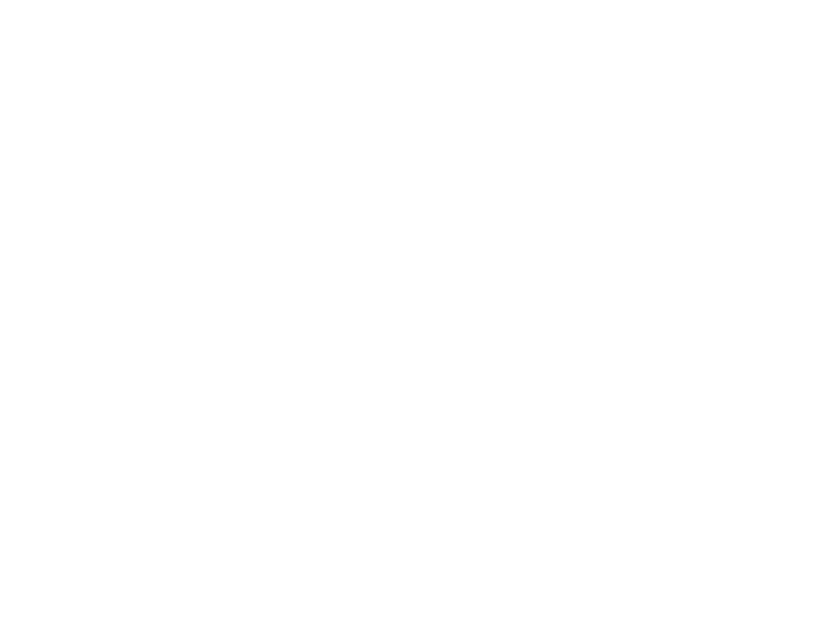

KeyboardInterrupt: 

In [134]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row_arms):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
#                 dr.drawArmCylinder(center_y, center_z, arm_start, arm_end)
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [414]:
print("List of the fruits that got passed over by vehicle")
print("ROW 0")
print(row_picture[0].passed_fruit)
print("ROW 1")
print(row_picture[1].passed_fruit)
print("ROW 2")
print(row_picture[2].passed_fruit)

List of the fruits that got passed over by vehicle
ROW 0
[72, 74, 75]
ROW 1
[]
ROW 2
[]
